# Problem Statement - Learning Facial Expressions
Use a labeled facial expression dataset to perform "deep learning" with a Convolutional Neural Network (CNN) to identify facial expressions (unlabeled)

In [1]:
# Importing dependencies

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from pathlib import Path
import pandas as pd
from keras.models import model_from_json
from pathlib import Path
from keras.preprocessing import image
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from matrix_util import *
import tensorflow as tf

Using TensorFlow backend.


# Dataset
Training set from https://github.com/muxspace/facial_expressions is a collection of public unprocessed images of faces and various expressions

# Cleaning up the Dataset

In [2]:
# importing CSV file containing image labels and corresponding image file names

path_to_labels="data/legend.csv"

data=pd.read_csv(path_to_labels)


# Data shape
14190 rows by 3column headings

In [3]:
data.tail()

,user.id,image,emotion
14185,906,Tim_Pawlenty_0001.jpg,neutral
14186,906,Tim_Robbins_0001.jpg,neutral
14187,906,Tim_Robbins_0002.jpg,neutral
14188,906,Tim_Robbins_0003.jpg,neutral
14189,906,Tim_Robbins_0004.jpg,happiness


### The user ID is not used for any of the analyis. It was a way to identify the student that 'gathered' the information. 

# Data Munging

## Converts all the strings in the emotion column to lower case

In [4]:
# Lower casing all the values in the emotion column

data['emotion'] = [str(i).lower() for i in data["emotion"]]

# Identified redundant labels
## Renamed labels to be uniform (sadness to sad)

In [5]:
# re-labelling all the columns labelled sad, with sadness for consistency

data['emotion']=data['emotion'].replace(to_replace='sadness', value='sad', regex=True)


# Final labels

## There are 8 labels but the team decided to focus on 4 major labels (Happiness, Sad, Anger, Neutral)

In [6]:
labels=list(data['emotion'].unique())
labels

['anger',
 'surprise',
 'disgust',
 'fear',
 'neutral',
 'happiness',
 'sad',
 'contempt']

In [7]:
# Pick 4 emotions of choice i.e. anger, neutral, happiness, sad

restricted_to_specific_emo=data.loc[data.emotion.isin(["anger","neutral","happiness","sad"])].reset_index(drop=True)
restricted_to_specific_emo.tail()

,user.id,image,emotion
13525,906,Tim_Pawlenty_0001.jpg,neutral
13526,906,Tim_Robbins_0001.jpg,neutral
13527,906,Tim_Robbins_0002.jpg,neutral
13528,906,Tim_Robbins_0003.jpg,neutral
13529,906,Tim_Robbins_0004.jpg,happiness


In [65]:
restricted_to_specific_emo.groupby('emotion').size()

emotion
anger         367
happiness    5893
neutral      6952
sad           318
dtype: int64

# After identifying the 4 expressions 
there are 13530 images

In [8]:
# Labels we are going to use

using_labels=list(restricted_to_specific_emo['emotion'].unique())
using_labels

['anger', 'neutral', 'happiness', 'sad']

# Use OPEN CV2 to generate array equivalent for all images

In [9]:
import cv2


In [10]:
# Taking the column name "image" from the dataframe labelled data and converting to list

img_file_names = list(restricted_to_specific_emo["image"])


In [11]:
# To get the array value of each file

grayscale_image_array=[]

for i in range(len(img_file_names)):
    img_path = f"images/{img_file_names[i]}"
    img = cv2.imread(img_path,0)
    grayscale_image_array.append(img)
    

## Identify all the images' size


In [12]:
# Count the number of images for each image size

(
    pd.DataFrame.from_records(
        [img.shape for img in grayscale_image_array],
        columns=['num_rows', 'num_cols'])
    .groupby(['num_rows', 'num_cols'])
    .size()
    .rename('num_images')
    .to_frame()
    .sort_values(by="num_images", ascending=False)
).head()

,,num_images
num_rows,num_cols,
350,350,12823
37,27,3
91,73,3
99,80,2
73,58,2


## There are 12823 uniform 350 by 350 pixel images
The team decided to work with these larger images filter out the remaining images, (13530-12823 = 707 images excluded)

In [13]:
# Taking the array values of all the images of size 350 by 350 and their corresponding emotion values and
# appending to new lists

grayscale_image_array_only_350by350=[]
emotions_only_350by350=[]


for i in range(len(grayscale_image_array)):
    img = grayscale_image_array[i]
    emotion = restricted_to_specific_emo.emotion[i]
    
    if img.shape == (350, 350):
        grayscale_image_array_only_350by350.append(img)
        emotions_only_350by350.append(emotion)

In [14]:
# Checking the size of the new lists

print(len(grayscale_image_array_only_350by350))
print(len(emotions_only_350by350))

12823
12823


# Data Augmentation
The images are being tranformed to 5 different orientations to generate a more robust training set.Each orientation is appended to it's respective list.

In [15]:
# Changing the orientation of the image in multiple ways to create a more robust data set which will then be used 
# to train and test the model

images_reflected_horizontally=[]

images_reflected_vertically=[]

images_rotated_right=[]

images_rotated_left=[]

images_rotated_180=[]


for i in range(len(grayscale_image_array_only_350by350)):
    
    # grabs images and assigns to img
    img=grayscale_image_array_only_350by350[i]
    
    #reflects the image horizontally and appends to images_reflected_horizontally list
    images_reflected_horizontally.append(reflect_horizontally(img))
    
    #reflects the image vertically and appends to images_reflected_vertically list
    images_reflected_vertically.append(reflect_vertically(img))
    
    #rotates the image right and appends to images_rotated_right list
    images_rotated_right.append(rotate_right(img))
    
    #rotates the image left and appends to images_rotated_left list
    images_rotated_left.append(rotate_left(img))
    
    #rotates the image 180 degrees and appends to images_rotated_180 list
    images_rotated_180.append(rotate_180(img))
    

# Collecting all the lists

In [16]:
# this is my final list of images (X) in various orientations

final_list_images= (
    grayscale_image_array_only_350by350 + 
    images_reflected_horizontally + 
    images_reflected_vertically +
    images_rotated_right +
    images_rotated_left+
    images_rotated_180
    
)

In [17]:
# These are the emotion labels (y) corresponding to the X images

final_list_emotions= emotions_only_350by350*6


# Reshaping the lists to create a usable array format for X and y variables (features and labels)


In [18]:
# Converting list grayscale_image_array_only_350by350 to array and reshaping the dimensions

X = np.concatenate([
    img.reshape(1,350,350,1)
    for img in
    final_list_images
])

In [19]:
X.shape

(76938, 350, 350, 1)

In [20]:
# converting the text label into a number between 0 and 3 (because 4 labels) and converting this to 
# an array and reshaping

label_to_number_map = {
    label: idx for idx, label in enumerate(using_labels)}

emo_numbers = [
    label_to_number_map[emo] for emo in final_list_emotions
]
emo_numbers_array = np.array(emo_numbers).reshape(-1, 1)

# Supervised Learning
Deep Learning - Convolutional Neural Networks (CNN) Model/Fit/Predict

In [21]:
# Converting the number into one hot encoding resulting in a matrix 

y = keras.utils.to_categorical(
    emo_numbers_array,
    len(using_labels))


In [22]:
# Creating a trained test split from the data

X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y)

#  Model

In [23]:
model = Sequential()

model.add(Conv2D(2, (3, 3), padding='same', input_shape=(350,350,1), activation="relu"))
model.add(Conv2D(2, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(4, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(4, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(8, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(8, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(16, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(16, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(4, activation="softmax"))

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Print a summary of the model
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 350, 350, 2)       20        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 348, 348, 2)       38        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 174, 174, 2)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 174, 174, 2)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 174, 174, 4)       76        
_________________________________________________________________
conv2d_4 (Conv2D)    

In [24]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from sklearn.metrics import accuracy_score

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3)

early_stopper = EarlyStopping(monitor='val_acc', min_delta=0, patience=6, mode='auto')

checkpointer = ModelCheckpoint('14_epochs_dropouts_weights.hd5', monitor='val_loss', verbose=1, save_best_only=True)



# Model Fit

In [25]:
# Run the model fit on the training test using the test set for validation

# history = model.fit(X_train,
#           y_train,
#           batch_size=32,
#           epochs=14,
#           validation_data=(X_test,y_test),
#           shuffle=True,
#           callbacks=[lr_reducer, checkpointer, early_stopper]
# )


In [26]:
# print(history)

In [27]:
# # This shows various accuracy and val loss for each epoch
# history.history

In [28]:
# model_structure = model.to_json()
# f = Path("model_structure.json")
# f.write_text(model_structure)

In [29]:
# # Save neural network's trained weights
# model.save_weights("model_weights.h5")
# model.save("model_trained.h5")


# Load the model for use

In [30]:
from keras.models import model_from_json
from pathlib import Path
from keras.preprocessing import image
import numpy as np

# Load the json file that contains the model's structure
f = Path("epochs/14_epochs_dropout/model_structure.json")
model_structure = f.read_text()

# Recreate the Keras model object from the json data
model = model_from_json(model_structure)

# Re-load the model's trained weights
model.load_weights("epochs/14_epochs_dropout/model_weights.h5")


# Building a Confusion Matrix

In [31]:
# Numerically coding the values of the y_test labels to intigers between 0 and 3 
# (as we are looking at 4 emotions)
y_test_numerical=[]

for i in range(len(y_test)):
    var=y_test[i]
    
    if var[0]==1:
        y_test_numerical.append(0)
        
    elif var[1]==1:
        y_test_numerical.append(1)
    
    elif var[2]==1:
        y_test_numerical.append(2)
    
    else:
        y_test_numerical.append(3)
        
    

In [32]:
# Make a prediction using the modeland test data (from the split)

results = model.predict(X_test)

In [33]:
# Numerically coding the values of the prediction labels to integers between 0 and 3
# (as we are looking at 4 emotions)

emotion_label=[]
predictions=[]
for i in range(len(results)):
    single_result = results[i]
    most_likely_class_index = int(np.argmax(single_result))
    class_likelihood = single_result[most_likely_class_index]

    class_label = using_labels[most_likely_class_index]
    emotion_label.append(class_label)
    if class_label=="anger":
        predictions.append(0)
    elif class_label=="neutral":
        predictions.append(1)
    elif class_label=="happiness":
        predictions.append(2)
    else:
        predictions.append(3)

In [34]:
emotion_label

['happiness',
 'neutral',
 'happiness',
 'happiness',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'happiness',
 'neutral',
 'neutral',
 'happiness',
 'happiness',
 'neutral',
 'happiness',
 'neutral',
 'happiness',
 'happiness',
 'neutral',
 'neutral',
 'happiness',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'happiness',
 'happiness',
 'neutral',
 'neutral',
 'neutral',
 'happiness',
 'happiness',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'happiness',
 'happiness',
 'happiness',
 'happiness',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'happiness',
 'neutral',
 'happiness',
 'neutral',
 'happiness',
 'happiness',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'happiness',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'happiness',
 'happiness',
 'happiness',
 'neutral',
 'happiness',
 'neutral',
 'happiness',
 'neutral',
 'neutra

In [35]:
# Making a confusion matrix using the values of the predictions and actual labelled test values
my_confusion_mat = confusion_matrix(y_test_numerical, predictions)

In [36]:
my_confusion_mat

array([[  30,  432,   51,    0],
       [   2, 9764,  436,    0],
       [  11, 1811, 6437,    0],
       [   0,  226,   35,    0]])

In [37]:
# Number of times each emotion label appears in the training set
my_confusion_mat.sum(axis=1).reshape(-1, 1)


array([[  513],
       [10202],
       [ 8259],
       [  261]])

# Percentage Confusion Matrix

In [38]:
perc_confusion_matrix=np.round(my_confusion_mat /
my_confusion_mat.sum(axis=1).reshape(-1, 1).repeat(4, axis=1),3
)
perc_confusion_matrix

array([[0.058, 0.842, 0.099, 0.   ],
       [0.   , 0.957, 0.043, 0.   ],
       [0.001, 0.219, 0.779, 0.   ],
       [0.   , 0.866, 0.134, 0.   ]])

In [39]:
import seaborn as sns

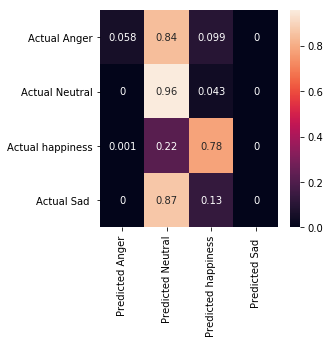

In [40]:
df_cm = pd.DataFrame(perc_confusion_matrix, index=["Actual Anger", "Actual Neutral", "Actual happiness", "Actual Sad "],
                  columns = ["Predicted Anger", "Predicted Neutral", "Predicted happiness", "Predicted Sad "])
plt.figure(figsize = (4,4))
sns.heatmap(df_cm, annot=True)


# Add images

# To look at specific images and predict the emotion

In [41]:
def look_up_emotions(image_path):
    
    # Load an image file to test, resizing it to 350 X 350 pixels (as required by this model)
    img = image.load_img(image_path, target_size=(350, 350),grayscale=True)

    # Convert the image to a numpy array
    image_to_test = image.img_to_array(img)

    # Add a fourth dimension to the image (since Keras expects a list of images, not a single image)
    list_of_images = np.expand_dims(image_to_test, axis=0)

    # Make a prediction using the model
    results = model.predict(list_of_images)

    # Since we are only testing one image, we only need to check the first result
    single_result = results[0]

    # We will get a likelihood score for all 10 possible classes. Find out which class had the highest score.
    most_likely_class_index = int(np.argmax(single_result))
    class_likelihood = single_result[most_likely_class_index]

    # Get the name of the most likely class
    class_label = using_labels[most_likely_class_index]

    # Print the result
    print(f"This is image has a {class_likelihood*100}% likelihood of being {class_label}")
    plt.imshow(img)


This is image has a 72.05533385276794% likelihood of being happiness


/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


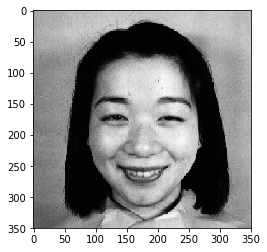

In [42]:
look_up_emotions("test/YM.HA2.53.jpg")

This is image has a 56.613147258758545% likelihood of being neutral


/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


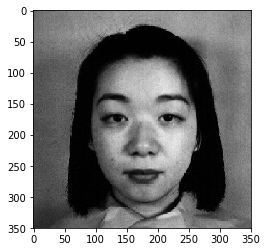

In [43]:
look_up_emotions("test/YM.NE2.50.jpg")

This is image has a 71.88626527786255% likelihood of being happiness


/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


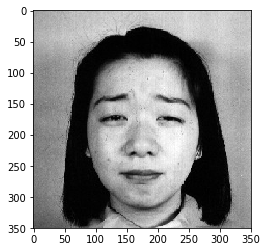

In [44]:
look_up_emotions("test/YM.SA2.56.jpg")

/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


This is image has a 78.1807541847229% likelihood of being happiness


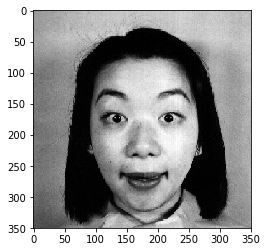

In [45]:
look_up_emotions("test/YM.SU2.59.jpg")

This is image has a 60.04868745803833% likelihood of being neutral


/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


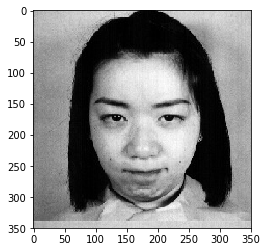

In [46]:
look_up_emotions("test/YM.AN2.62.jpg")

/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


This is image has a 76.48870944976807% likelihood of being neutral


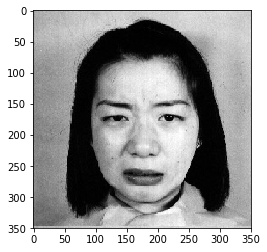

In [47]:
look_up_emotions("test/YM.DI2.65.jpg")

/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


This is image has a 88.66718411445618% likelihood of being happiness


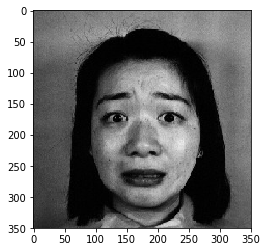

In [48]:
look_up_emotions("test/YM.FE2.68.jpg")

This is image has a 74.09319877624512% likelihood of being neutral


/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


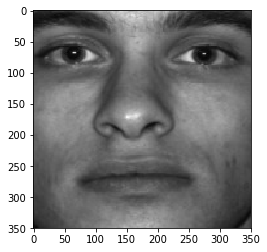

In [49]:
look_up_emotions("test/y17.jpg")

This is image has a 71.89869284629822% likelihood of being neutral


/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


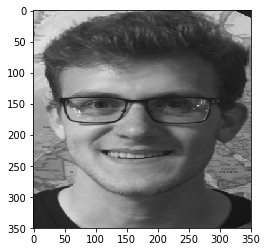

In [61]:
look_up_emotions("/Users/muhammadwaliji/Desktop/3.jpg")

## Comments:
##### 1. Model is most consistently good at picking up Neutral and Happy facial expressions
##### 2. Anger and Sad expressions are not picked up as well. 
##### 3. Further investigation into the data set revealed that some of the images were not labelled as consistently as others especially for the anger and sadness facial expression
##### 4. Another reason that may lead to inaccurate labelling for anger and sadness is beacuse in the test set there are only 513 images for anger and 261 images for sadness. In comparison, there are 10202 neutral images and 8259 happiness images. This massive discrepiency in the training set is contributing to the mislabelling
